In [5]:
import pandas as pd
from binance.client import Client
import backtrader as bt
import matplotlib.pyplot as plt
import mplfinance as mpf
import itertools
import numpy as np
import seaborn as sns
%matplotlib inline
import yfinance as yf
from sklearn.model_selection import TimeSeriesSplit
import time
from datetime import datetime, timedelta
from itertools import product

### Premise on the workflow
This workflow is designed to closely follow my thought process. At points where the code is modified from earlier versions, I explain the reasons behind the changes, including any mistakes identified and the rationale for improvements. This approach aims to provide transparency into the development and analysis steps, helping the reader understand why certain adjustments were made. At points it might have been better to simply rewrite the old code, but this would miss the thinking process.

# Momentum + SMA crossover strategy development plan


## 1. Strategy Implementation  

### Momentum strategy  
- Use **momentum indicator** over a lookback window to detect trends  
- Adjust position sizing dynamically based on volatility (ATR) and conviction (momentum strength × volume)  
- Generate buy signals when momentum > threshold and SMA fast crosses above SMA slow  
- Generate sell signals when momentum < -threshold and SMA fast crosses below SMA slow  

### SMA Crossover strategy  
- Define **short-term (fast) and long-term (slow) SMAs** as additional signals  
- Generate buy signals when fast SMA crosses above slow SMA  
- Generate sell signals when fast SMA crosses below slow SMA  


## 2. Backtesting engine  
- Use the **Backtrader framework** to simulate historical trades for both strategies  
- Feed combined historical data for indicators and price  
- Implement cross-validation using **TimeSeriesSplit** to test on multiple time periods  
- Collect final portfolio values for performance comparison  


## 3. Performance analysis  
- Calculate key metrics for each strategy and their combinations:  
  - Total return  
  - Sharpe Ratio  
  - Maximum Drawdown  
  - Win Rate (percentage of profitable trades)  
- Compare momentum-only, SMA-only, and combined strategy performance  


## 4. Visualization  
- Plot price charts with buy/sell markers for each strategy  
- Overlay SMA lines and momentum indicators (e.g., momentum score or ATR)  
- Show equity curves side-by-side to visualize strategy growth over time  
- Highlight drawdown periods  



## 5. Parameter Optimization & Cross Validation  
- Perform grid search over key hyperparameters such as:  
  - Momentum lookback window  
  - Momentum threshold  
  - SMA fast and slow periods  
  - ATR period for volatility adjustment  
- Use **cross-validation** with multiple time splits to avoid overfitting  
- Evaluate average final portfolio value or Sharpe ratio as optimization target  



## 6. Conclusion and Insights  
- Summarize how momentum and SMA crossover strategies individually and jointly perform  
- Discuss when momentum signals are more effective and when SMA crossovers help  
- Reflect on:  
  - Strengths and weaknesses of each approach  
  - Impact of volatility and conviction weighting on position sizing  
  - Future improvements: adding machine learning signals, risk management (e.g., drawdown control), or more complex indicators  


## Initial model

We will start small. We are going to begin by implementing a very basic momentum trading strategy and then go ahead from there.
- If the price has gone up a lot over the last $N$ days, we buy
- If the price has dropped over the last $N$ days, we sel

For this purpose we are going to use ```backtrader```


We are going to create a ```MomentumStrategy``` class where we we calculate the momentum over the last ```lookback``` days using the formula: $$
\text{Momentum}_t = \frac{P_t - P_{t - L}}{P_{t - L}} = \frac{P_t}{P_{t - L}} - 1
$$

In [11]:
class MomentumStrategy(bt.Strategy):
    params = (
        ('lookback', 20),
        ('threshold', 0.01),
        ('trade_size', 0.1),
    )

    def __init__(self):
        self.equity_curve = []

    def next(self):
        if len(self) < self.p.lookback:
            self.equity_curve.append(self.broker.getvalue())
            return  # not enough data yet

        momentum = (self.data.close[0] / self.data.close[-self.p.lookback]) - 1
        size = (self.broker.getvalue() * self.p.trade_size) / self.data.close[0]

        # SELL condition
        if momentum < -self.p.threshold and self.position.size > 0:
            self.close()

        # BUY condition
        elif momentum > self.p.threshold and not self.position:
            if size > 0:
                self.buy(size=size)
            else:
                print("Calculated size too small to buy")

        self.equity_curve.append(self.broker.getvalue())


We start by defining key parameters such as lookback, threshold, and trade_size. The momentum is calculated using these parameters based on historical price data.

- In the ```next``` method, we first check if we have enough data to calculate momentum. Once we have enough information, we compute the momentum value.

- If the momentum falls below the negative threshold and we currently hold a position, we sell to exit the trade.

Conversely, if the momentum rises above the positive threshold and we do not hold any position, we buy a calculated amount of shares based on our portfolio size and the **trade_size** parameter.

### Doing backtesting on the small engine

For the purpose of backtesting I am going to use "Cerebro engine". Before doing that I will run ```pip install python-binance``` to get access to information about the market.

In [12]:


# We will need no API key since the data is public
client = Client()

# Fetch historical klines (candles) for BTCUSDT, 1h interval, last 1000 candles
klines = client.get_historical_klines("BTCUSDT", Client.KLINE_INTERVAL_1HOUR, "1000 hours ago UTC")

# Convert to DataFrame and select columns
df = pd.DataFrame(klines, columns=[
    'Open time', 'Open', 'High', 'Low', 'Close', 'Volume',
    'Close time', 'Quote asset volume', 'Number of trades',
    'Taker buy base asset volume', 'Taker buy quote asset volume', 'Ignore'])

# Convert timestamps to datetime
df['Open time'] = pd.to_datetime(df['Open time'], unit='ms')
df['Close time'] = pd.to_datetime(df['Close time'], unit='ms')

# Keep only useful columns for backtesting
df = df[['Open time', 'Open', 'High', 'Low', 'Close', 'Volume']]

# Convert columns to float
df[['Open', 'High', 'Low', 'Close', 'Volume']] = df[['Open', 'High', 'Low', 'Close', 'Volume']].astype(float)

# Set 'Open time' as the datetime index for mplfinance compatibility
df.set_index('Open time', inplace=True)

print(df.head())


                          Open       High        Low      Close     Volume
Open time                                                                 
2025-06-01 21:00:00  104948.91  105504.67  104926.82  105496.54  414.58616
2025-06-01 22:00:00  105496.54  105737.84  105414.63  105512.18  474.08063
2025-06-01 23:00:00  105512.17  105866.91  105466.39  105642.93  413.01524
2025-06-02 00:00:00  105642.93  105735.42  105404.31  105427.48  432.43804
2025-06-02 01:00:00  105427.48  105658.38  105349.63  105388.59  368.13444


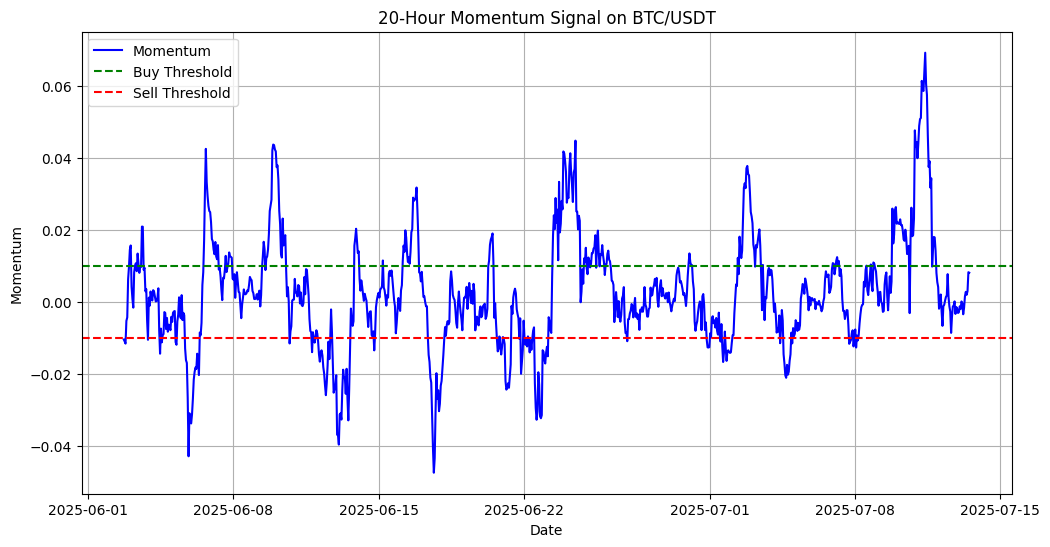

In [13]:
lookback = 20

# Make sure data is float (you already do this above)
df['momentum'] = df['Close'].pct_change(lookback)

# Drop NaNs and plot
plt.figure(figsize=(12, 6))
plt.plot(df.index[lookback:], df['momentum'].dropna(), label='Momentum', color='blue')
plt.axhline(y=0.01, color='green', linestyle='--', label='Buy Threshold')
plt.axhline(y=-0.01, color='red', linestyle='--', label='Sell Threshold')
plt.title(f'{lookback}-Hour Momentum Signal on BTC/USDT')
plt.xlabel('Date')
plt.ylabel('Momentum')
plt.legend()
plt.grid(True)
plt.show()


Now we plotted, starting from the first of june up until now, how the momentul is changing each they as well as plotted the threshholds for buying and selling.

Now that we have our data that we are going to work with we can plot it to see how it looks like.

C:\Users\mitko\AppData\Local\Programs\Python\Python310\lib\site-packages\mplfinance\_arg_validators.py:84: UserWarning: 


            POSSIBLE TO SEE DETAILS (Candles, Ohlc-Bars, Etc.)
   For more information see:
   - https://github.com/matplotlib/mplfinance/wiki/Plotting-Too-Much-Data
   
   TO SILENCE THIS WARNING, set `type='line'` in `mpf.plot()`
   OR set kwarg `warn_too_much_data=N` where N is an integer 
   LARGER than the number of data points you want to plot.

  warnings.warn('\n\n ================================================================= '+


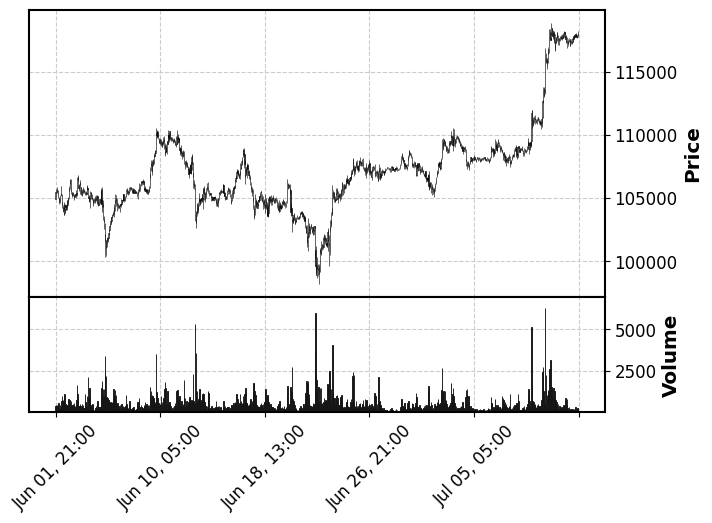

In [14]:

mpf.plot(df, type='candle', volume=True, style='classic')

plt.show()

Now that we can visually see we can go forward and try to do simple backtesting. Before that I will rename the columns for conviniency.

In [15]:
df.rename(columns={
    'Open': 'open',
    'High': 'high',
    'Low': 'low',
    'Close': 'close',
    'Volume': 'volume'
}, inplace=True)

Let us create a datafeed.

In [16]:
datafeed = bt.feeds.PandasData(dataname=df)

In [17]:
INITIAL_CASH = 10000
cerebro = bt.Cerebro()

cerebro.addstrategy(MomentumStrategy, lookback=20, threshold=0.02, trade_size=0.1) # We also can adjust the params here.

cerebro.adddata(datafeed)

cerebro.broker.setcash(INITIAL_CASH)

# I am not going to set commission since we assume that we are trading in a firm and have no commissions.
# cerebro.broker.set_fundmode(True)
results = cerebro.run()

In [18]:
print(f"Final Portfolio Value: {cerebro.broker.getvalue():.2f}")

Final Portfolio Value: 10094.67


I want to notice that I used to get a value 10000 for the portfolio. Therefore no trades were made. We have not bought, our position stays at zero, we can not sell. Where is this problem coming from? After some observation we can notice that we are using ```size = int((self.broker.getvalue() * self.p.trade_size) / close_price)``` which returns 0 if the value is less than 0. Since we are buyin Bitcoins, we are never buying more than 1 bitcoin at a time. After removing the parsing to int the problem is no longer there.

Okey, we got a result and we see that we have increased our portfolio with 37 dollars, which is about 0.37%. It is a possitive increase but not hing impresive. Let us analyze some more this result before moving to improvements.

In [19]:
cerebro.addanalyzer(bt.analyzers.TradeAnalyzer, _name='trades')
cerebro.addanalyzer(bt.analyzers.SharpeRatio_A, _name='sharpe', timeframe=bt.TimeFrame.Days)
cerebro.addanalyzer(bt.analyzers.DrawDown, _name='drawdown')

In [20]:
results = cerebro.run()
strat = results[0]


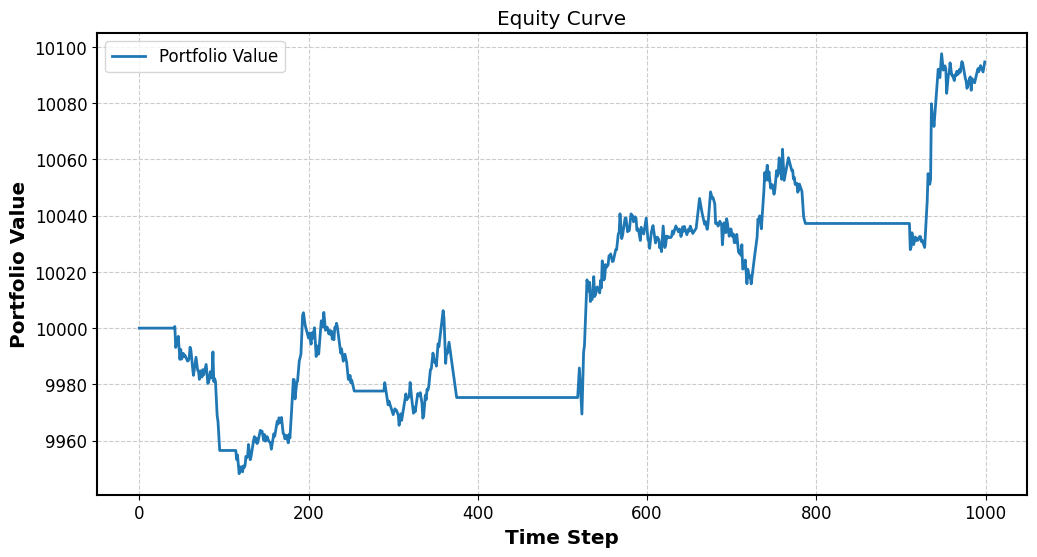

In [21]:
plt.figure(figsize=(12, 6))
plt.plot(strat.equity_curve, label='Portfolio Value')
plt.title('Equity Curve')
plt.xlabel('Time Step')
plt.ylabel('Portfolio Value')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:

trade_stats = strat.analyzers.trades.get_analysis()

# Total trades
total_trades = trade_stats.total.total
open_trades = trade_stats.total.open
closed_trades = trade_stats.total.closed

# Wins and losses
won = trade_stats.won.total
lost = trade_stats.lost.total

# PnL
total_net_pnl = trade_stats.pnl.net.total
average_net_pnl = trade_stats.pnl.net.average

print(f"Total trades: {total_trades}")
print(f"Open trades: {open_trades}")
print(f"Closed trades: {closed_trades}")
print(f"Winning trades: {won}")
print(f"Losing trades: {lost}")
print(f"Total Net PnL: {total_net_pnl:.2f}")
print(f"Average Net PnL: {average_net_pnl:.2f}")

In [ ]:
sharpe = strat.analyzers.sharpe.get_analysis()
drawdown = strat.analyzers.drawdown.get_analysis()

print("Sharpe Ratio:", sharpe.get('sharperatio', 'N/A'))
print(f"Max Drawdown: {drawdown.drawdown:.2f}%")
print(f"Drawdown Duration: {drawdown.len} bars")

### Improving the simple model
Based on the information above, we can conclude that our model functions but is far from optimal. Next, we will work on making it more complex and improving its performance. The first thing that might come to mind is how we actually decide on the hyperparameters we are using such as the threshhold and the trade size. There are a couple approaches when it comes to choosing those:


- **Grid Search**  
  Try all combinations of discrete values

- **Random Search**  
  Randomly sample combinations from the hyperparameter space

- **Bayesian Optimization**  
  Use prior evaluations to guide the search (e.g., maximize Sharpe ratio)

- **Walk-Forward Optimization**  
  1. Train on time window $$[t, t+k]$$  
  2. Test on $$[t+k+1, t+2k]$$  
  3. Slide the window forward


Before implementing GridSearch, we should ensure that the parameter values are not chosen arbitrarily, but are instead grounded in reasonable assumptions and sound trading principles. For instance, a trade size of 0.3 or 0.4 is clearly unreasonable, as it allocates a disproportionately large portion of the capital to a single trade, which significantly increases risk.

In [ ]:
class BinanceData(bt.feeds.PandasData):
    params = (
        ('datetime', None),
        ('open', 'Open'),
        ('high', 'High'),
        ('low', 'Low'),
        ('close', 'Close'),
        ('volume', 'Volume'),
        ('openinterest', -1),
    )
lookbacks = [10, 20, 50]
thresholds = [0.005, 0.01, 0.02]
trade_sizes = np.arange(0.01,0.1,0.01)

results = []

for lookback, threshold, trade_size in itertools.product(lookbacks, thresholds, trade_sizes):
    cerebro = bt.Cerebro()
    cerebro.addstrategy(MomentumStrategy,
                        lookback=lookback,
                        threshold=threshold,
                        trade_size=trade_size)
    
    data = BinanceData(dataname=df)
    cerebro.adddata(data)

    cerebro.broker.setcash(10000)
    cerebro.broker.setcommission(commission=0)
    cerebro.run()

    final_value = cerebro.broker.getvalue()
    results.append({
        'lookback': lookback,
        'threshold': threshold,
        'trade_size': trade_size,
        'final_value': final_value
    })
results_df = pd.DataFrame(results)
results_df = results_df.sort_values(by='final_value', ascending=False)

print(" Top Results:")
print(results_df.head())

## Momentum with SMA

If we make the trade size bigger we will notice that we can increase the final value, however this comes with a lot of risk. For now we will leave that and do something else. **Our model is still extremely simply and we are going to make it a bit more complex.** I am going to try and implement a **SMA crossover.** For this purpose I will
- Define short-term and long-term SMAs  
- Generate **buy signals** when the short SMA crosses above the long SMA  
- Generate **sell signals** when the short SMA crosses below the long SMA

Let's add this to our model.

In [ ]:

class MomentumStrategyWithSMA(bt.Strategy):
    params = (
        ('lookback', 20),
        ('threshold', 0.01),
        ('trade_size', 0.1),
        ('sma_fast_period', 10),  # short-term SMA
        ('sma_slow_period', 30),  # long-term SMA
    )
    
    def __init__(self):
        self.sma_fast = bt.indicators.SimpleMovingAverage(self.data.close, period=self.p.sma_fast_period)
        self.sma_slow = bt.indicators.SimpleMovingAverage(self.data.close, period=self.p.sma_slow_period)
        self.crossover = bt.indicators.CrossOver(self.sma_fast, self.sma_slow)  # +1 when fast crosses above slow, -1 when below
    
    def next(self):
        if len(self.data) < max(self.p.lookback, self.p.sma_slow_period):
            return  # wait until enough data

        momentum = (self.data.close[0] / self.data.close[-self.p.lookback]) - 1
        size = (self.broker.getvalue() * self.p.trade_size) / self.data.close[0]

        # SELL condition: momentum < -threshold AND fast SMA crosses below slow SMA
        if momentum < -self.p.threshold and self.position.size > 0 and self.crossover < 0:
            self.close()

        # BUY condition: momentum > threshold AND fast SMA crosses above slow SMA
        elif momentum > self.p.threshold and not self.position and self.crossover > 0:
            if size > 0:
                self.buy(size=size)
            else:
                print("Calculated size too small to buy")


In [ ]:
def run_backtest(strategy_class,data, **strategy_params):
    cerebro = bt.Cerebro()
    cerebro.addstrategy(strategy_class, **strategy_params)
    cerebro.adddata(data)
    cerebro.broker.setcash(INITIAL_CASH)
    # Add analyzers
    cerebro.addanalyzer(bt.analyzers.TradeAnalyzer, _name='trades')
    cerebro.addanalyzer(bt.analyzers.SharpeRatio_A, _name='sharpe', timeframe=bt.TimeFrame.Days)
    cerebro.addanalyzer(bt.analyzers.DrawDown, _name='drawdown')

    results = cerebro.run()
    strat = results[0]

    trade_stats = strat.analyzers.trades.get_analysis()
    sharpe = strat.analyzers.sharpe.get_analysis()
    drawdown = strat.analyzers.drawdown.get_analysis()

    total_trades = trade_stats.get('total', {}).get('total', 0)
    won = trade_stats.get('won', {}).get('total', 0)
    lost = trade_stats.get('lost', {}).get('total', 0)
    pnl_total = trade_stats.get('pnl', {}).get('net', {}).get('total', 0)
    pnl_avg = trade_stats.get('pnl', {}).get('net', {}).get('average', 0)
    
    print(f"Strategy: {strategy_class.__name__}")
    print(f"Total trades: {total_trades}")
    print(f"Winning trades: {won}")
    print(f"Losing trades: {lost}")
    print(f"Total Net PnL: {pnl_total:.2f}")
    print(f"Average Net PnL: {pnl_avg:.2f}")
    print("Sharpe Ratio:", sharpe.get('sharperatio', 'N/A'))
    print(f"Max Drawdown: {drawdown.drawdown:.2f}%")
    print(f"Drawdown Duration: {drawdown.len} bars")
    print("===================================")


In [ ]:
run_backtest(MomentumStrategy,datafeed, lookback=20, threshold=0.01, trade_size=0.1)
run_backtest(MomentumStrategyWithSMA,datafeed, lookback=20, threshold=0.01, trade_size=0.1, sma_fast_period=10, sma_slow_period=50)



In [ ]:

def grid_search_strategy(strategy_class, param_grid, data_df, initial_cash=10000, commission=0):
    """
    Perform grid search over strategy hyperparameters.

    Parameters:
        strategy_class: The Backtrader strategy class to test.
        param_grid: dict of parameter name -> list of values.
        data_df: pandas DataFrame with OHLCV data.
        initial_cash: starting capital for each backtest.
        commission: broker commission.

    Returns:
        pandas DataFrame with each parameter combination and final portfolio value.
    """

    # Build all parameter combinations
    keys, values = zip(*param_grid.items())
    param_combinations = [dict(zip(keys, v)) for v in itertools.product(*values)]

    results = []
    total_runs = len(param_combinations)
    print(f"Total backtests to run: {total_runs}")

    for i, params in enumerate(param_combinations):
        # Skip invalid combos, e.g. fast SMA >= slow SMA
        if 'sma_fast_period' in params and 'sma_slow_period' in params:
            if params['sma_fast_period'] >= params['sma_slow_period']:
                continue

        # if i % 10 == 0:
            print(f"Running backtest {i + 1}/{total_runs} with params: {params}")

        cerebro = bt.Cerebro()
        cerebro.addstrategy(strategy_class, **params)

        data = bt.feeds.PandasData(dataname=data_df)
        cerebro.adddata(data)

        cerebro.broker.setcash(initial_cash)
        cerebro.broker.setcommission(commission=commission)

        cerebro.run()
        final_value = cerebro.broker.getvalue()

        results.append({**params, 'final_value': final_value})

    results_df = pd.DataFrame(results).sort_values(by='final_value', ascending=False).reset_index(drop=True)
    return results_df


In [ ]:
param_grid = {
    'lookback': [20, 50, 100],  # added longer lookback
    'threshold': [ 0.01, 0.02, 0.03],  # wider range for momentum trigger
    'trade_size': [0.01, 0.05, 0.1],
    'sma_fast_period': [30, 20],  # a slightly longer fast SMA
    'sma_slow_period': [ 50, 100, 200],  # longer slow SMAs for multi-year trends
}
results_df = grid_search_strategy(MomentumStrategyWithSMA, param_grid, df)
print(results_df.head())

Now we can see how our new model performs with different hyperparameters. We see that there are lots of cases where we get a positive final_value but there is also one important thing missing and it is information about the trades made. This is imprtant since we cannot rely on algorithms that have simply performed little to none trades that turned out to be lucky. Let's check some more statistics.

In [ ]:
top_5 = results_df.head(5)
print("Top results with SMA:")
print(results_df.head())
for _, row in top_5.iterrows():
    if 'sma_fast_period' in row and not pd.isna(row['sma_fast_period']):
        run_backtest(MomentumStrategyWithSMA,datafeed,
                     lookback=int(row['lookback']),
                     threshold=row['threshold'],
                     trade_size=row['trade_size'],
                     sma_fast_period=int(row['sma_fast_period']),
                     sma_slow_period=int(row['sma_slow_period']))
    else:
        run_backtest(MomentumStrategy,datafeed,
                     lookback=int(row['lookback']),
                     threshold=row['threshold'],
                     trade_size=row['trade_size'])

The insights we get from that are extremely valiable. 
- Firstly we execute little to no trades. This means that the information could be missleading.
- Secondly, although the sharpe ration is good, we have not met one of the **assumptions** it has - following a normal distribuution.

Probably the best thing we could do right now is to try and extend the period of our data since we are only using the last 1000 hours.

In [ ]:
from binance.client import Client
import pandas as pd

# No API key needed for public data
client = Client()

# Function to fetch hourly data for up to 3 years
def fetch_hourly_data(symbol="BTCUSDT", years=3):
    interval = Client.KLINE_INTERVAL_1HOUR
    end_time = datetime.utcnow()
    start_time = end_time - timedelta(days=365 * years)
    
    df_list = []
    while start_time < end_time:
        # Convert to string
        start_str = start_time.strftime("%d %b %Y %H:%M:%S")
        try:
            klines = client.get_historical_klines(symbol, interval, start_str, limit=1000)
            if not klines:
                break
            
            temp_df = pd.DataFrame(klines, columns=[
                'Open time', 'Open', 'High', 'Low', 'Close', 'Volume',
                'Close time', 'Quote asset volume', 'Number of trades',
                'Taker buy base asset volume', 'Taker buy quote asset volume', 'Ignore'])

            temp_df['Open time'] = pd.to_datetime(temp_df['Open time'], unit='ms')
            temp_df['Close time'] = pd.to_datetime(temp_df['Close time'], unit='ms')
            temp_df = temp_df[['Open time', 'Open', 'High', 'Low', 'Close', 'Volume']]
            temp_df[['Open', 'High', 'Low', 'Close', 'Volume']] = temp_df[['Open', 'High', 'Low', 'Close', 'Volume']].astype(float)
            df_list.append(temp_df)

            # Step forward 1000 hours
            start_time = temp_df['Open time'].iloc[-1] + timedelta(hours=1)
            time.sleep(0.5)  # Respect API rate limits
        except Exception as e:
            print("Error:", e)
            time.sleep(1)
    
    full_df = pd.concat(df_list).set_index('Open time')
    return full_df

# Fetch 3 years of data
df_2 = fetch_hourly_data(years=3)

print(df.head())
print(df.tail())
print(f"Total candles: {len(df_2)}")


In [ ]:

mpf.plot(df_2, type='candle', volume=True, style='classic')

plt.show()

In [ ]:
run_backtest(MomentumStrategyWithSMA,
                     lookback=int(row['lookback']),
                     threshold=row['threshold'],
                     trade_size=row['trade_size'],
                     sma_fast_period=int(row['sma_fast']),
                     sma_slow_period=int(row['sma_slow']))

Now lets run the tests we had but on the new data

In [ ]:
datafeed_2 = bt.feeds.PandasData(dataname=df_2)
run_backtest(MomentumStrategy,datafeed_2, lookback=20, threshold=0.01, trade_size=0.1)
run_backtest(MomentumStrategyWithSMA,datafeed_2, lookback=100, threshold=0.01, trade_size=0.1, sma_fast_period=50, sma_slow_period=168)



## Momentum with stop-loss

In [ ]:


class MomentumStrategyWithSMAstopLoss(bt.Strategy):
    params = (
        ('lookback', 20),
        ('threshold', 0.01),
        ('trade_size', 0.1),
        ('sma_fast_period', 10),  # short-term SMA
        ('sma_slow_period', 30),  # long-term SMA
        ('stop_loss_pct', 0.02),  # 2% stop loss by default
    )
    
    def __init__(self):
        self.sma_fast = bt.indicators.SimpleMovingAverage(self.data.close, period=self.p.sma_fast_period)
        self.sma_slow = bt.indicators.SimpleMovingAverage(self.data.close, period=self.p.sma_slow_period)
        self.crossover = bt.indicators.CrossOver(self.sma_fast, self.sma_slow)  # +1 when fast crosses above slow, -1 when below
        self.stop_price = None  # to track stop loss level

    def next(self):
        if len(self.data) < max(self.p.lookback, self.p.sma_slow_period):
            return  # wait until enough data

        momentum = (self.data.close[0] / self.data.close[-self.p.lookback]) - 1
        size = (self.broker.getvalue() * self.p.trade_size) / self.data.close[0]

        # Check stop loss first
        if self.position.size > 0 and self.stop_price is not None:
            if self.data.close[0] <= self.stop_price:
                self.log(f'STOP LOSS TRIGGERED: Closing position at {self.data.close[0]:.2f}')
                self.close()
                self.stop_price = None
                return  # no further action on this bar after stop loss

        # SELL condition: momentum < -threshold AND fast SMA crosses below slow SMA
        if momentum < -self.p.threshold and self.position.size > 0 and self.crossover < 0:
            self.log(f'SELL signal: Closing position at {self.data.close[0]:.2f}')
            self.close()
            self.stop_price = None

        # BUY condition: momentum > threshold AND fast SMA crosses above slow SMA
        elif momentum > self.p.threshold and not self.position and self.crossover > 0:
            if size > 0:
                self.buy(size=size)
                # Set stop loss price after buying
                self.stop_price = self.data.close[0] * (1 - self.p.stop_loss_pct)
                self.log(f'BUY signal: Buying at {self.data.close[0]:.2f} with stop loss at {self.stop_price:.2f}')
            else:
                print("Calculated size too small to buy")

    def log(self, txt):
        dt = self.datas[0].datetime.date(0)
        print(f'{dt.isoformat()} - {txt}')


In [ ]:
run_backtest(MomentumStrategyWithSMAstopLoss,datafeed_2, lookback=100, threshold=0.01, trade_size=0.1, sma_fast_period=50, sma_slow_period=250)

To manage risk using a stop-loss step, we observe that while the maximum drawdown decreases, the number of losing trades increases. This reflects a trade-off that must be considered. An alternative approach is to use the Average True Range (ATR), which adjusts the stop-loss dynamically based on market volatility. Additionally, techniques like Grid Search can be employed to optimize the stop-loss level based on historical performance.

# Dynamic position sizing
In this section, I will implement dynamic position sizing to improve trade management.

**More about the concept can be found in the notebook: Premise, research.ipynb**

We will use three core ideas to determine trade size more effectively:

- **Volatility Adjustment:** Reduce trade size in more volatile markets using ATR.

- **Conviction Score:** Increase size when both momentum and volume agree (strong signal).

- **Drawdown Awareness:** Reduce size after consecutive losses to protect capital.

In [ ]:

class MomentumStrategyWithSMApositionSizing(bt.Strategy):
    params = (
        ('lookback', 20),
        ('threshold', 0.01),
        ('trade_size', 0.1),
        ('sma_fast_period', 10),
        ('sma_slow_period', 30),
        ('atr_period', 14),
    )

    def __init__(self):
        self.sma_fast = bt.indicators.SimpleMovingAverage(self.data.close, period=self.p.sma_fast_period)
        self.sma_slow = bt.indicators.SimpleMovingAverage(self.data.close, period=self.p.sma_slow_period)
        self.crossover = bt.indicators.CrossOver(self.sma_fast, self.sma_slow)
        self.atr = bt.indicators.ATR(self.data, period=self.p.atr_period)
        self.buy_signals = []   # I am adding those to store signals if we want to plot where we sell and where we buy
        self.sell_signals = []

        self.max_equity = None  # track max equity for drawdown adjustment

    def next(self):
        if len(self.data) < max(self.p.lookback, self.p.sma_slow_period, self.p.atr_period):
            return

        momentum = (self.data.close[0] / self.data.close[-self.p.lookback]) - 1

        # Base size
        size = (self.broker.getvalue() * self.p.trade_size) / self.data.close[0]

        #  ATR-based volatility adjustment 
        atr = self.atr[0]
        if atr > 0:
            size /= (1 + atr / self.data.close[0])

        # Conviction score
        momentum_score = max(0, (momentum - self.p.threshold)) * 100  # scaled
        volume_mean = sum(self.data.volume.get(size=self.p.lookback, ago=-1)) / self.p.lookback
        volume_score = self.data.volume[0] / volume_mean if volume_mean > 0 else 1
        conviction_multiplier = min(momentum_score * volume_score, 2.0)
        size *= conviction_multiplier

        # Drawdown-aware size reduction
        current_equity = self.broker.getvalue()
        if self.max_equity is None or current_equity > self.max_equity:
            self.max_equity = current_equity
        drawdown = (self.max_equity - current_equity) / self.max_equity
        if drawdown > 0.05:
            size *= max(0.5, 1 - drawdown * 2)

       # Here is the logic
        if momentum < -self.p.threshold and self.position.size > 0 and self.crossover < 0:
            self.close()
            self.sell_signals.append((self.data.datetime.datetime(0), self.data.close[0]))

        elif momentum > self.p.threshold and not self.position and self.crossover > 0:
            if size > 0:
                self.buy(size=size)
                self.buy_signals.append((self.data.datetime.datetime(0), self.data.close[0]))
            else:
                print("Calculated size too small to buy")


In [ ]:
run_backtest(MomentumStrategyWithSMApositionSizing)

### Note on Risk Management

In this implementation, no explicit stop-loss mechanism is used. Instead, the strategy employs adaptive position sizing to mitigate risk. When market conditions deteriorate - such as during increased volatility, weakening momentum, or account drawdowns - the size of new trades is systematically reduced.

This approach serves as a soft alternative to traditional stop-losses, as it minimizes capital at risk during unfavorable conditions without prematurely exiting positions. However, this method does not preclude the use of stop-losses; both techniques can be combined to create a layered risk management framework that balances flexibility with protective constraints.

In [ ]:
run_backtest(MomentumStrategyWithSMApositionSizing,datafeed_2, lookback=200, threshold=0.01, trade_size=0.1, sma_fast_period=50, sma_slow_period=350)

Now if we want we could print a graph and show when buys and sells are executed using the signal lists.

In [ ]:
param_grid = {
    'lookback': [20, 50],
    'threshold': [0.01, 0.02],
    'trade_size': [0.05, 0.1],
    'sma_fast_period': [20],
    'sma_slow_period': [50, 100],
    'atr_period': [14],
}

#### Note
I am not using many parameters since each backtesting for the df_2 data takes a lot of time

In [ ]:
results_df = grid_search_strategy(MomentumStrategyWithSMApositionSizing, param_grid, df_2)
print(results_df.head())

In [ ]:
run_backtest(MomentumStrategyWithSMApositionSizing,datafeed_2, lookback=50, threshold=0.02, trade_size=0.1, sma_fast_period=20,sma_slow_period = 50,atr_period = 14)

Here we have only tried 16 combinations but with enough computational power we could increase them significantly. After all that we could see that we can make a good net profit. Let us take for example a strategy with a return of 13500 and start of 10000:
#### Annualized Return Calculation

We assume an initial investment of \\$10,000 that grows to \\$13,500 over 3 years.

To compute the average annual return, we use the **Compound Annual Growth Rate (CAGR)** formula:

$$
\text{CAGR} = \left( \frac{V_f}{V_i} \right)^{\frac{1}{n}} - 1
$$

Where:
- $ V_f = 13,500 $ is the final value,
- $ V_i = 10,000 $ is the initial value,
- $ n = 3 $ years.

Substituting in the values:

$$
\text{CAGR} = \left( \frac{13,500}{10,000} \right)^{\frac{1}{3}} - 1 = (1.35)^{\frac{1}{3}} - 1 \approx 0.1057
$$

So the **annualized return is approximately 10.57% per year**.


However, there is another concern to address in this situation. Even though we may have found a strategy with a winning rate that **outperforms benchmarks like the S&P 500, bonds, or even traditional banks**, we must be cautious.

The danger lies in the fact that we may simply be **adapting to the asset's historical behavior**, selecting only the parameter combinations that *happen to have worked well* — not because of sound logic, but by chance. This might be overfitting and might perform bad on unseen data.

If we were dealing with a machine learning problem **we would approach this using k-fold cross validation and test train splits.** However since we are working with time series the solution to this problem will require other methods. We could use **Time Series Cross-Validation:**
- **Expanding window:** You increase the training size with each fold.

- **Rolling window:** Keep training window size fixed and roll it forward.

- **Walk-Forward Validation**
    - You **retrain the model at each step** using the latest available data.
    - Each forecast is made for **a single time point** or **a small forecast horizon**.



For the sake of time, I will implement only one of the following strategies, acknowledging that more could be explored and the best one chosen based on the specific asset.

### Implementing Time series cross validation

In this section I will try to implement a time series cross validation with grid search in order to **choose the best params while not overfitting the model. Firstly we are going to import ```from sklearn.model_selection import TimeSeriesSplit.```

Now we will approach that in the following order:
1. **Define a grid of params**
2. **Define the cross-validation function**
3. **Run the grid search with cross validation**


In [ ]:
param_grid = {
    'lookback': [20, 50],
    'threshold': [0.01, 0.02],
    'trade_size': [0.05, 0.1],
    'sma_fast_period': [10, 20],
    'sma_slow_period': [30, 50],
    'atr_period': [14],
}

param_combinations = list(product(*param_grid.values()))
param_names = list(param_grid.keys())

In [ ]:
def cross_validate_strategy(df, strategy_cls, param_dict, n_splits=3):
    tscv = TimeSeriesSplit(n_splits=n_splits)
    final_values = []

    for train_index, test_index in tscv.split(df):
        df_train = df.iloc[train_index].copy()
        df_test = df.iloc[test_index].copy()

        cerebro = bt.Cerebro()
        cerebro.addstrategy(strategy_cls, **param_dict)

        data = bt.feeds.PandasData(dataname=pd.concat([df_train, df_test])) # use full data so indicators work
        cerebro.adddata(data)

        cerebro.broker.setcash(10000)
        cerebro.broker.setcommission(commission=0)
        cerebro.run()

        final_values.append(cerebro.broker.getvalue())

    avg_value = sum(final_values) / len(final_values)
    return avg_value


In [ ]:
type(results)

In [ ]:
results = []
counter = 1
for combo in param_combinations:
    print(counter)
    param_dict = dict(zip(param_names, combo))
    
    if param_dict['sma_fast_period'] >= param_dict['sma_slow_period']:
        continue

    avg_final_value = cross_validate_strategy(df_2, MomentumStrategyWithSMApositionSizing, param_dict)

    results.append({
        **param_dict,
        'avg_final_value': avg_final_value
    })
    counter+=1

# Convert to DataFrame
import pandas as pd
results_df = pd.DataFrame(results)
results_df = results_df.sort_values(by='avg_final_value', ascending=False)
print(results_df.head())


In [ ]:
run_backtest(MomentumStrategyWithSMApositionSizing,datafeed_2,**param_dict) # This backtest however is not using cross validation but shows us some info.

This function, however, takes some time to perform, since we not only have to test it on all the different hyperparameter combinations, but also do cross-validation on different time periods of the data. Nevertheless, this is not inherently bad, it is expected and even necessary to ensure that the strategy is robust and not overfitting to a specific period. Investing this computational effort helps us find hyperparameters that generalize well across various market conditions, ultimately leading to more reliable and consistent performance in live trading.

#### Note
We must also mention that for parameter optimization we could use Random Search or Bayesian Optimization in order to lower the computation time.

## Multiple assets evaluation

It is visible that we can keep modifying our algorithm by adding RSI or bollinger bands, etc. However, I will try to use the simple algorithm we have developed up until now and test it on more then one asset. 

**It is important to say that I am going to choose assets that are expected to have a momentum attitude. This could be considered p-hacking, but in our case it is not, since our model works on the assumption that the stock follows a momentum flow.**

In [ ]:
symbols = ["NVDA", "MTUM", "BTC-USD", "ICLN", "SPMO","AAPL","AMD","TSLA","QQQ","IWM"]
data_dict = {}

for symbol in symbols:
    try:
        df = yf.download(symbol, period="3y", interval="1d")
        data_dict[symbol] = df
        print(f"Fetched data for {symbol}")
    except Exception as e:
        print(f"Error fetching {symbol}: {e}")

I am fetching the data from Yahoo Finance since the Binance contains only crypto currency data

In [ ]:
strategy_params = {
    'lookback': 20,
    'threshold': 0.01,
    'trade_size': 0.1,
    'sma_fast_period': 20,
    'sma_slow_period': 50,
    'atr_period': 14,
}

# Now loop through all symbols
for symbol, df in data_dict.items():
    print(f"\nRunning backtest for {symbol}...")

    if isinstance(df.columns, pd.MultiIndex):
        df.columns = df.columns.get_level_values(0)

    # Create Backtrader datafeed from each DataFrame
    datafeed = bt.feeds.PandasData(dataname=df)

    # Run backtest for this datafeed and strategy
    run_backtest(MomentumStrategyWithSMApositionSizing, datafeed, **strategy_params)

Our strategy shows varied performance across different assets. NVDA and AMD demonstrate strong profitability with favorable Sharpe ratios and controlled drawdowns, indicating effective momentum capture. Conversely, ICLN struggles significantly with consistent losses and a negative Sharpe ratio. Overall, the strategy performs better on high-volume tech stocks and less effectively on some ETFs and sector-specific assets. Drawdown durations suggest the strategy generally recovers steadily, though some assets show prolonged periods of stagnation or risk exposure. 

But overall the strategy is winning. Although we take risk and there are moments of drawdown, we were able to obtain a positive tho mild Sharpe ration

**Also we see that our model has strict rules which allows only for little but more secure trades to be captured.**

### Resources 
- https://medium.com/funny-ai-quant/momentum-based-strategy-optimization-with-grid-search-on-backtrader-8c0d6cd1cc36
- https://www.a1trading.com/how-to-calculate-the-right-lot-size-for-forex-trading/#:~:text=To%20calculate%20the%20correct%20lot%20size%20for%20a,away%20is%20your%20stop%20loss%20from%20your%20entry%3F
- https://quantstrattrader.com/2016/01/13/on-the-relationship-between-the-sma-and-momentum/